<a href="https://colab.research.google.com/github/hyunbini/Project/blob/main/IDSL_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from google.colab.patches import cv2_imshow
import requests

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


User-defined Function used in code

In [24]:
def check_nan(file):
  result = file.isnull().sum()
  return result

In [25]:
#Function that extracts user_id who wrote one or more reviews
#Input : series(pandas dataframe)
#Output : result(list)
def make_list(series1):
  result = []
  for i in range(series1.size):
    #Add user_id who have written reviews more than once to the new list
    if series1[i]>1:
      result.append(series1.index[i])
  return result

In [26]:
#Function that labels data composed of complex characters numerically based on ascending order\
#Input : list1(list to be replaced), list2(reference list), dic(dictionary to store the values of reference list and its unique labeling numbers)
#Output : list_df(Dataframe made from a labeled list)
def labeling_user_id(list1,list2,dic):
  i = 0
  for data in list1:
    if data in list2:
      if data in dic.keys():
        list1[i] = dic[data]
      else:
        dic[data] = i
        list1[i] = i
      i = i+1
    else:
      list1[i] = i
      i = i+1
  for y in range(len(list1)):
    list1[y] = list1[y]+1
  list_df = pd.DataFrame(data=list1, columns= ['labeling_user_id'])
  return list_df

In [27]:
#Function that make a list with data that goes up from zero to a list that goes up in ascending order
#Input : dataframe
#Output : list
def make_label_list(dataset_name):
  emptylist = []
  for i in range(len(dataset_name)):
    emptylist.append(i)
    i = i+1
  list_df_1 = pd.DataFrame(data=emptylist, columns=['labeling_list'])
  return list_df_1

In [28]:
#Function that removes unnecessary sentence symbols, case-sensive, and meaningless word in a sentence to vectorize
#Input : string
#Output : string
def text_preprocessing(column):
    #Make all words with lower letters
    column = column.str.lower()
    #Remove unnecessary punctuation marks
    column = column.str.replace('[-=+,#?^@*\"※~ㆍ!』‘|\(\)\[\]\{\}`\'…》\"\"\“\’·]', '', case=False)
    #Spliting each sentence to words to apply erase meaningless word
    word_tokens = column.str.split()
    keywords = word_tokens.apply(lambda x: [item for item in x if item not in stop])
    #assemble words of each sentence again and assign them in new column
    for i in range(len(keywords)):
        keywords[i] = " ".join(keywords[i])
        column = keywords
    return column

In [29]:
#Function that receives the parent_asin of the review product user wrote using the user_id after receiving the user_id
#Input : float
#Output : string
def found_asin(user_id):
  label = reviewdata['user_id']
  label_df_list = label.to_list()
  save_asin = []
  for data in label_df_list:
    if data == user_id:
      save_asin.append(data)
  if (len(save_asin)) == 1:
    return reviewdata[reviewdata['user_id'] == user_id]['parent_asin'].values[0]
  elif (len(save_asin)) > 1:
    for data_1 in save_asin:
      high_data = float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])
      if float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])>high_data:
        high_value = float(reviewdata[reviewdata['user_id']==data_1]['rating'].values[0])
      else:
        high_value = high_data
    return reviewdata[reviewdata['rating']==high_value]['parent_asin'].values[0]
  else:
    print("Wrong User_id, Please try again 1~70883.")

In [30]:
#Function to find the details of the product that fit parent_asin
#Input : string
#Output : string
def found_data(asin_id):
  asindata = metadata['parent_asin']
  asindata_df_list = asindata.to_list()
  for dt in asindata_df_list:
    if dt == asin_id:
      return metadata[metadata['parent_asin'] == asin_id]['details'].values[0]

In [31]:
#Reference code : https://nyagya.tistory.com/8
#Function that receives the url for the product and show the image
#Input : string
#Output : Image or String
def image_show(dataurl):
    dataurl_str = ''.join(dataurl)
    url = re.sub('[=+,#?^@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', "",dataurl_str)
    dataurl_list = url.split()
    url_list = [s for s in dataurl_list if "https://" in s][0]
    url_data = ''.join(url_list)
    image_nparray = np.asarray(bytearray(requests.get(url_data).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    if str(type(image)) == "<class 'numpy.ndarray'>":
      image_final = cv2.resize(image,(100,100))
      cv2_imshow(image_final)
      cv2.waitKey(0)
    else:
      print("Sorry, There is no image for this product.")

In [32]:
#Fucntion that find product information which user already bought
#Input : dataframe, string
#Output : string
def getinfo_review(dataname,asin):
  title = dataname[dataname['parent_asin']==asin]['title'].values[0]
  price = dataname[dataname['title']==title]['price'].values[0]
  rating = reviewdata[reviewdata['parent_asin']==asin]['rating'].values[0]
  data = str(dataname[dataname['title']==title]['images'].values[0])
  print(title,price,rating)
  return data

In [33]:
#Fucntion that find product information which recommend new product based on user's review
#Input : dataframe, int, string
#Output : string
def getinfo_new(dataname,ranknum,titlename):
  rank = ranknum
  rating = dataname[dataname['title']==titlename]['average_rating'].values[0]
  price = dataname[dataname['title']==titlename]['price'].values[0]
  detail = dataname[dataname['title']==titlename]['details'].values[0]
  data = str(dataname[dataname['title']==titlename]['images'].values[0])
  print(rank,titlename,rating,price,detail)
  return data

In [34]:
#Function that create a list of recommedation list
#Input : int, dataframe, array
#Output : list or tuple
def recommendation_model(asin,preddata,modeling):
  #Run the code when details information are not available
  if preddata.empty==True:
    #Get the main category information that user already bought
    category_info =metadata[metadata['parent_asin']==asin]['main_category'].values[0]
    #Sort the data in order of average rating
    pred_category_data = metadata[metadata['main_category']==category_info].sort_values(by=['average_rating'],ascending=False)
    #Separate labeling_list and average_rating required for output
    pred_category_label_list = pred_category_data[['labeling_list','average_rating']]
    #Change dataframe to the list
    pred_category_label = pred_category_label_list.values.tolist()
    #Hang up in the top 10 because there are so many data
    pred_item_list_based_cg = pred_category_label[0:5]
    print('These products with high ratings among those in the same category as those purchased recently.')
    return pred_item_list_based_cg
  #Run the code when details information are available
  else:
    pred_labeling_id = preddata['labeling_list'].values[0]
    #Calculation of similarity with cosine similarity
    pred_score_list = list(enumerate(modeling[pred_labeling_id]))
    #Sort the similar product in descending order
    pred_sorted_score = sorted(pred_score_list, key=lambda x:x[1], reverse= True)
    #Ignore the first score because it's the same, also hang up in the top 10 because there are so many data
    pred_item_list_based_cs = pred_sorted_score[1:6]
    print('These products have similarity and details to the recently purchased products.')
    return pred_item_list_based_cs

Import Data and Remove NaN Value and Unuseful Columns



In [35]:
meta_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/metadata.json')
review_json = pd.read_json('/content/drive/MyDrive/IDSL Recruitment/[Data 1] Eng - Review Analysis/reviews.json')
print(meta_json.head())
print(review_json.head())
print(check_nan(meta_json))
print(check_nan(review_json))

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating  rating_number  \
0             4.8             10   
1             3.7             35   
2             3.7              2   
3             3.3              4   
4             3.4             10   

                                            features  \
0                                                 []   
1  [The false toenails are durable with perfect l...   
2  [Extatic Balmain Gold Musk By Balmain Edt Spra...   
3                                                 []   
4                                                 []   

                         

In [36]:
meta = meta_json.drop(['rating_number','categories','videos', 'features', 'bought_together', 'subtitle', 'author'],axis = 1)
print(meta.head())
reviewdata = review_json.drop(['title', 'text','images','timestamp','helpful_vote','verified_purchase','asin'],axis=1)
print(reviewdata.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                        description  price  \
0             4.8                                                 []   None   
1             3.7  [Description, The false toenails are durable w...   6.99   
2             3.7             [Edt spray 3 oz design house: balmain]  86.95   
3             3.3                                                 []   79.5   
4             3.4                                                 []   None   

                                              images            store  \
0  {'hi_res': [None, 'https://m

Extracting duplicate data and labeling of the user_id value to be used for prediction

In [37]:
id = reviewdata['user_id']
print("The total number of reviews is", id.size)
id_count = (id.value_counts())
print("The user who wrote the review is", id_count.size)

The total number of reviews is 70883
The user who wrote the review is 68934


In [38]:
#Create only unique values of the user_id as a list
dup_ind = make_list(id_count)
user_id = id.to_list()
label_dic = {}
reviewdata['user_id'] = labeling_user_id(user_id,dup_ind,label_dic)

<ipython-input-25-e8b33d3049f5>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series1[i]>1:


In [39]:
#Create a product label to use when extracting a recommend product in the prediction part
new_label_df = make_label_list(meta)

In [40]:
#Combine meta and new_label_df dataset into one dataframe
metadata = pd.concat([meta,new_label_df],axis=1)
print(metadata.head())
print(reviewdata.head())

  main_category                                              title  \
0    All Beauty  Howard LC0008 Leather Conditioner, 8-Ounce (4-...   
1    All Beauty  Lurrose 100Pcs Full Cover Fake Toenails Artifi...   
2    All Beauty                         Gold extatic Musk EDT 90ml   
3    All Beauty  Brand New Headrang Face line Contour V-line Ma...   
4    All Beauty  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...   

   average_rating                                        description  price  \
0             4.8                                                 []   None   
1             3.7  [Description, The false toenails are durable w...   6.99   
2             3.7             [Edt spray 3 oz design house: balmain]  86.95   
3             3.3                                                 []   79.5   
4             3.4                                                 []   None   

                                              images            store  \
0  {'hi_res': [None, 'https://m

Modeling

In [41]:
#Get details data for text processing
details_df = metadata['details']
details_str_df = details_df.astype(str)
tp_details_df = text_preprocessing(details_str_df)

In [42]:
CV = CountVectorizer()
#Make metrix used string
converted_metrix = CV.fit_transform(tp_details_df)
cs_result = cosine_similarity(converted_metrix)

Prediction

Please enter your own user_id : 9000
Tangle Teezer | The Large Ultimate Detangler Hairbrush for Wet & Dry Hair | Long, Thick, Curly, Textured Hair | Eliminates Knots & Reduces Breakage | Popping Pink None 5


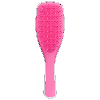

In [54]:
id = input("Please enter your own user_id : ")
id_float = int(id)
review_parent_asin = found_asin(id_float)
#Get the product information that user have already bought
already_buy_data = getinfo_review(metadata,review_parent_asin)
image_show(already_buy_data)
#Get the product details that user have already bought
user_inform_data = found_data(review_parent_asin)
pred_data = metadata[metadata['details'].str.contains(user_inform_data)]

These products have similarity and details to the recently purchased products.
1 HAIRART H3000 Black Tourmaline 2-3/8” Round Brush (Model: H3107) (Pack of 1) 2.3 None {"Brand": "Hairart", "Shape": "Round", "Product Benefits": "Smoothing", "Unit Count": "1.00 Count", "Hair Type": "All", "Package Dimensions": "10 x 2.5 x 2.5 inches; 3.2 Ounces"}
Sorry, There is no image for this product.
2 Goody Styling Essentials Brush, Woodgrain Professional - 2 Count 3.9 None {"Brand": "Goody Styling Essentials", "Shape": "Oblong", "Unit Count": "2.00 Count", "Hair Type": "All", "Product Dimensions": "8 x 2 x 2 inches; 4 Ounces"}


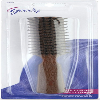

3 Wet Brush Original Detangler Disney Princess Collection Bundle (Ariel - Pocahontas) 4.8 None {"Brand": "Wet Brush", "Shape": "Oblong", "Product Benefits": "Detangle", "Unit Count": "1.00 Count", "Hair Type": "All"}


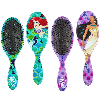

4 2 Pack Pink Detangling Brush for Curly Hair, ez Detangler Brush Hair Detangler, Afro Textured 3a to 4c Kinky Wavy for Wet/Dry/Long Thick Curly Hair, ExfoliatingYour Scalp for Beautiful and Shiny Curls 3.5 None {"Brand": "NONE BRANDED", "Shape": "Oblong", "Handle Material": "Rubber", "Unit Count": "2.00 Count", "Hair Type": "Wavy, Dry, Curly, Thick", "Product Dimensions": "9.5 x 2.2 x 1.3 inches; 5.61 Ounces", "UPC": "767410166107"}


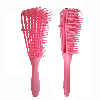

5 BKpearl 2 Pack Detangling Brush for Curly Hair, Hair Detangler Comb Afro Textured 3a to 4c Kinky Wavy for Wet Dry Long Curly Hair, Exfoliating Your Scalp for Beautiful and Shiny Curls 4.1 None {"Brand": "BKpearl", "Handle Material": "Rubber", "Product Benefits": "Detangle", "Unit Count": "1.00 Count", "Hair Type": "Wavy, Dry, Curly, Thick", "Package Dimensions": "11.18 x 6.69 x 2.05 inches; 8.64 Ounces", "UPC": "619156276018 619156276001"}


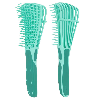

In [55]:
rank = 1
result_list = recommendation_model(review_parent_asin,pred_data,cs_result)
for item in result_list:
    #Get the product information that recommend based on cosine similarity
    product_item = int(item[0])
    title = metadata[metadata['labeling_list'] == product_item]['title'].values[0]
    data = getinfo_new(metadata,rank,title)
    image_show(data)
    rank = rank+1